In [48]:
import torch
import numpy as np
import pandas as pd
from functools import reduce

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from XBNet.training_utils import training,predict
from XBNet.models import XBNETClassifier
from XBNet.run import run_XBNET

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Data Preprocessing

In [25]:
data = pd.read_csv('df.csv')

In [33]:
# sentiment analysis
analyzer = SentimentIntensityAnalyzer()
data['sentiment'] = [analyzer.polarity_scores(x)['compound'] for x in data['text']]

In [50]:
data

,user_id,prod_id,rating,label,date,text,review_count,compound,date_format
0,923,0,3,-1,8/12/14,The food at snack is a selection of popular Gr...,NaN,0.6170,2014-08-12
1,924,0,3,-1,16/5/13,This little place in Soho is wonderful. I had ...,NaN,0.5783,2013-05-16
2,925,0,4,-1,1/7/13,ordered lunch for 15 from Snack last Friday. ...,NaN,0.8515,2013-01-07
3,926,0,4,-1,28/7/11,This is a beautiful quaint little restaurant o...,NaN,0.9785,2011-07-28
4,927,0,4,-1,1/11/10,Snack is great place for a casual sit down lu...,NaN,0.9756,2010-01-11
...,...,...,...,...,...,...,...,...,...
358952,161146,349,5,1,6/2/14,"I'm very spoiled with Pizza. Really, I have tr...",NaN,0.9951,2014-06-02
358953,116424,349,5,1,31/1/14,Can't say enough good things about this place....,NaN,0.9824,2014-01-31
358954,161147,349,5,1,30/1/14,"Had a great dinner here- fantastic pizza, the ...",NaN,0.9788,2014-01-30
358955,97930,349,5,1,25/1/14,"Great foods and great drinks, they have even p...",NaN,0.9682,2014-01-25


In [36]:
def std(x): 
    return np.std(x)

In [45]:
data['date_format'] = pd.to_datetime(data['date'])

In [98]:
data = data.sort_values(by=['date_format'])

In [99]:
data['day_diff'] = data.groupby('user_id')['date_format'].apply(lambda x: x.shift(-1) - x)

In [159]:
x = data[data['day_diff'].notna()]

In [160]:
x['day_diff'] = x['day_diff'].dt.days

/Users/jabezlee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Extracting Features

In [162]:
# Average Rating
avg_rating = x.groupby('user_id').mean()[['rating']]
avg_rating.rename(columns={'rating':'avg_rating'}, inplace=True)

# Average Sentiment
avg_sentiment = x.groupby('user_id').mean()[['compound']]
avg_sentiment.rename(columns={'compound':'avg_sentiment'}, inplace=True)

# Group Time Window
avg_time_window = x.groupby('user_id').mean()[['day_diff']]
avg_time_window.rename(columns={'day_diff':'avg_time_window'}, inplace=True)

# Review Count
review_count = x.groupby('user_id').count()[['rating']]
review_count.rename(columns={'rating':'review_count'}, inplace=True)

# No of products reviewed
no_of_products = x.groupby('user_id')[['prod_id']].nunique()
no_of_products.rename(columns={'prod_id':'no_of_products'}, inplace=True)

# Rating Deviation
rating_deviation = x.groupby('user_id')['rating'].agg([std])

In [163]:
data_frames = [avg_rating, avg_sentiment, avg_time_window, review_count, rating_deviation]

In [164]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['user_id'],
                                            how='outer'), data_frames)

In [165]:
df_merged = df_merged.reset_index()
df_merged.head(5)

,user_id,avg_rating,avg_sentiment,avg_time_window,review_count,std
0,923,4.447368,0.870511,15.894737,38,0.849067
1,925,4.000000,0.851500,0.000000,1,0.000000
2,927,3.500000,0.962375,78.750000,4,1.118034
3,930,3.500000,0.151300,748.500000,2,0.500000
4,931,4.200000,0.762227,21.000000,30,0.832666


In [166]:
x = x[['user_id', 'prod_id', 'rating', 'label', 'date_format', 'text', 'compound']]
x.rename(columns={'compound':'sentiment'}, inplace=True)
x.head(5)

/Users/jabezlee/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,user_id,prod_id,rating,label,date_format,text,sentiment
58336,19015,142,5,1,2004-09-12,"Really lovely Italian food, very simple and we...",0.9756
172752,30262,468,4,1,2004-10-20,Excellent Soup Dumplings. It's a must if you g...,0.7430
58335,25178,142,5,1,2005-01-04,The pasta bolognese is worth five stars all on...,0.8935
200527,76285,510,4,1,2005-01-08,"Had to wait for an hour, but at least they let...",0.3166
338725,24825,890,5,1,2005-01-10,"The ""Bistro Burger"" gets my vote for best burg...",0.6369


In [167]:
final_df = pd.merge(x, df_merged, on = 'user_id', how = 'left')

In [170]:
final_df['review_length'] = [len(x.split()) for x in final_df['text'].tolist()]

In [172]:
final_df.head(5)

,user_id,prod_id,rating,label,date_format,text,sentiment,avg_rating,avg_sentiment,avg_time_window,review_count,std,review_length
0,19015,142,5,1,2004-09-12,"Really lovely Italian food, very simple and we...",0.9756,4.000000,0.902714,165.285714,7,1.414214,56
1,30262,468,4,1,2004-10-20,Excellent Soup Dumplings. It's a must if you g...,0.7430,4.166667,0.924067,197.000000,6,0.687184,36
2,25178,142,5,1,2005-01-04,The pasta bolognese is worth five stars all on...,0.8935,5.000000,0.947925,33.500000,4,0.000000,129
3,76285,510,4,1,2005-01-08,"Had to wait for an hour, but at least they let...",0.3166,4.111111,0.855500,26.888889,9,0.737028,44
4,24825,890,5,1,2005-01-10,"The ""Bistro Burger"" gets my vote for best burg...",0.6369,5.000000,0.836186,117.000000,7,0.000000,12


In [173]:
fraud = final_df[final_df['label'] == -1]
benign = final_df[final_df['label'] == 1]

In [174]:
fraud = fraud.sample(n = 4000)
benign = benign.sample(n = 1000)

In [179]:
frames = [fraud, benign]
result = pd.concat(frames)

In [180]:
result = result[['sentiment', 'avg_rating', 'avg_sentiment', 'avg_time_window', 'review_count', 'std', 'review_length', 'rating', 'label']]

In [181]:
result

,sentiment,avg_rating,avg_sentiment,avg_time_window,review_count,std,review_length,rating,label
190,0.9757,4.200000,0.762227,21.000000,30,0.832666,91,5,-1
146438,0.2244,5.000000,0.224400,0.000000,1,0.000000,40,5,-1
25677,0.4512,3.000000,0.451200,0.000000,1,0.000000,38,3,-1
165869,0.9759,4.000000,0.975900,0.000000,1,0.000000,68,4,-1
143366,0.6588,5.000000,0.658800,2.000000,1,0.000000,2,5,-1
...,...,...,...,...,...,...,...,...,...
134718,0.9480,4.416667,0.746992,80.333333,12,0.640095,123,5,1
52645,0.9914,2.666667,0.447400,322.666667,3,1.247219,161,4,1
121673,0.9736,3.776119,0.853973,18.522388,67,0.911304,192,4,1
143158,0.9797,4.380000,0.944234,64.000000,50,0.596322,189,4,1


In [184]:
x_data = result[result.columns[:-1]]
print(x_data.shape)
y_data = result[result.columns[-1]]
le = LabelEncoder()
y_data = np.array(le.fit_transform(y_data))
print(le.classes_)

(5000, 8)
[-1  1]


In [185]:
X_train,X_test,y_train,y_test = train_test_split(x_data.to_numpy(),y_data,test_size = 0.2,random_state = 0)


In [210]:
model = XBNETClassifier(X_train,y_train,2)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


Enter dimensions of linear layers: 
Enter input dimensions of layer 1: 10
Enter output dimensions of layer 1: 10
Set bias as True or False: False
Enter input dimensions of layer 2: 10
Enter output dimensions of layer 2: 10
Set bias as True or False: False
Enter your last layer 
1. Sigmoid 
2. Softmax 
3. None 
3


/Users/jabezlee/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Percentage training completed:   0%|          | 1/300 [00:21<1:48:31, 21.78s/it]

Training Loss after epoch 1 is 0.781598846912384 and Accuracy is 78.8
Validation Loss after epoch 1 is 0.5108795762062073 and Accuracy is 78.8


Percentage training completed:   1%|          | 2/300 [00:44<1:51:12, 22.39s/it]

Training Loss after epoch 2 is 0.683770690202713 and Accuracy is 77.875
Validation Loss after epoch 2 is 0.6191742420196533 and Accuracy is 74.2


Percentage training completed:   1%|          | 3/300 [01:07<1:52:30, 22.73s/it]

Training Loss after epoch 3 is 0.6350500010251999 and Accuracy is 78.95
Validation Loss after epoch 3 is 0.48165464401245117 and Accuracy is 79.0


Percentage training completed:   1%|▏         | 4/300 [01:31<1:53:49, 23.07s/it]

Training Loss after epoch 4 is 0.5649594396352768 and Accuracy is 79.7
Validation Loss after epoch 4 is 0.4605238139629364 and Accuracy is 80.9


Percentage training completed:   2%|▏         | 5/300 [01:40<1:27:57, 17.89s/it]

Training Loss after epoch 5 is 0.5315174520015716 and Accuracy is 79.6
Validation Loss after epoch 5 is 0.4636854827404022 and Accuracy is 80.2


Percentage training completed:   2%|▏         | 6/300 [01:47<1:10:37, 14.41s/it]

Training Loss after epoch 6 is 0.5577385761737823 and Accuracy is 79.225
Validation Loss after epoch 6 is 0.47929108142852783 and Accuracy is 79.4


Percentage training completed:   2%|▏         | 7/300 [01:55<59:54, 12.27s/it]  

Training Loss after epoch 7 is 0.4956183255910873 and Accuracy is 80.325
Validation Loss after epoch 7 is 0.4576035737991333 and Accuracy is 80.3


Percentage training completed:   3%|▎         | 8/300 [02:02<51:50, 10.65s/it]

Training Loss after epoch 8 is 0.5006056581735611 and Accuracy is 80.375
Validation Loss after epoch 8 is 0.4565424919128418 and Accuracy is 80.3


Percentage training completed:   3%|▎         | 9/300 [02:09<45:32,  9.39s/it]

Training Loss after epoch 9 is 0.4952572274208069 and Accuracy is 80.475
Validation Loss after epoch 9 is 0.5138222575187683 and Accuracy is 79.1


Percentage training completed:   3%|▎         | 10/300 [02:16<41:35,  8.61s/it]

Training Loss after epoch 10 is 0.4780711506605148 and Accuracy is 80.725
Validation Loss after epoch 10 is 0.5162149667739868 and Accuracy is 78.6


Percentage training completed:   4%|▎         | 11/300 [02:23<39:58,  8.30s/it]

Training Loss after epoch 11 is 0.46697618770599364 and Accuracy is 80.8
Validation Loss after epoch 11 is 0.471078485250473 and Accuracy is 79.2


Percentage training completed:   4%|▍         | 12/300 [02:30<38:04,  7.93s/it]

Training Loss after epoch 12 is 0.45921467995643617 and Accuracy is 80.9
Validation Loss after epoch 12 is 0.46212369203567505 and Accuracy is 79.8


Percentage training completed:   4%|▍         | 13/300 [02:37<36:04,  7.54s/it]

Training Loss after epoch 13 is 0.458127206325531 and Accuracy is 80.525
Validation Loss after epoch 13 is 0.47416555881500244 and Accuracy is 79.6


Percentage training completed:   5%|▍         | 14/300 [02:44<35:32,  7.46s/it]

Training Loss after epoch 14 is 0.45002385234832765 and Accuracy is 81.15
Validation Loss after epoch 14 is 0.4662800431251526 and Accuracy is 79.7


Percentage training completed:   5%|▌         | 15/300 [02:52<35:35,  7.49s/it]

Training Loss after epoch 15 is 0.44746586191654203 and Accuracy is 81.45
Validation Loss after epoch 15 is 0.4602125585079193 and Accuracy is 79.6


Percentage training completed:   5%|▌         | 16/300 [03:00<36:23,  7.69s/it]

Training Loss after epoch 16 is 0.44518748915195466 and Accuracy is 81.3
Validation Loss after epoch 16 is 0.46037784218788147 and Accuracy is 79.4


Percentage training completed:   6%|▌         | 17/300 [03:08<36:27,  7.73s/it]

Training Loss after epoch 17 is 0.4454519203901291 and Accuracy is 81.4
Validation Loss after epoch 17 is 0.4579542577266693 and Accuracy is 79.3


Percentage training completed:   6%|▌         | 18/300 [03:16<36:28,  7.76s/it]

Training Loss after epoch 18 is 0.5218637652397156 and Accuracy is 80.275
Validation Loss after epoch 18 is 0.4651331603527069 and Accuracy is 80.4


Percentage training completed:   6%|▋         | 19/300 [03:24<36:46,  7.85s/it]

Training Loss after epoch 19 is 0.4961253184080124 and Accuracy is 80.8
Validation Loss after epoch 19 is 0.46447306871414185 and Accuracy is 79.7


Percentage training completed:   7%|▋         | 20/300 [03:32<36:47,  7.88s/it]

Training Loss after epoch 20 is 0.44585533928871157 and Accuracy is 81.35
Validation Loss after epoch 20 is 0.45955556631088257 and Accuracy is 79.2


Percentage training completed:   7%|▋         | 21/300 [03:40<36:56,  7.95s/it]

Training Loss after epoch 21 is 0.44400396502017975 and Accuracy is 81.575
Validation Loss after epoch 21 is 0.45736339688301086 and Accuracy is 79.6


Percentage training completed:   7%|▋         | 22/300 [03:47<36:22,  7.85s/it]

Training Loss after epoch 22 is 0.44355322790145874 and Accuracy is 81.55
Validation Loss after epoch 22 is 0.45680058002471924 and Accuracy is 79.7


Percentage training completed:   8%|▊         | 23/300 [03:55<35:59,  7.80s/it]

Training Loss after epoch 23 is 0.4435441836118698 and Accuracy is 81.475
Validation Loss after epoch 23 is 0.45638421177864075 and Accuracy is 79.6


Percentage training completed:   8%|▊         | 24/300 [04:03<36:12,  7.87s/it]

Training Loss after epoch 24 is 0.4435621143579483 and Accuracy is 81.475
Validation Loss after epoch 24 is 0.4562898874282837 and Accuracy is 79.9


Percentage training completed:   8%|▊         | 25/300 [04:11<35:50,  7.82s/it]

Training Loss after epoch 25 is 0.4430887635946274 and Accuracy is 81.45
Validation Loss after epoch 25 is 0.4569028913974762 and Accuracy is 79.6


Percentage training completed:   9%|▊         | 26/300 [04:19<35:44,  7.83s/it]

Training Loss after epoch 26 is 0.4448557926416397 and Accuracy is 81.425
Validation Loss after epoch 26 is 0.45904359221458435 and Accuracy is 79.6


Percentage training completed:   9%|▉         | 27/300 [04:27<36:29,  8.02s/it]

Training Loss after epoch 27 is 0.4440069303512573 and Accuracy is 81.625
Validation Loss after epoch 27 is 0.45817458629608154 and Accuracy is 79.2


Percentage training completed:   9%|▉         | 28/300 [04:36<37:53,  8.36s/it]

Training Loss after epoch 28 is 0.4584340478181839 and Accuracy is 81.25
Validation Loss after epoch 28 is 0.4531198740005493 and Accuracy is 80.6


Percentage training completed:  10%|▉         | 29/300 [04:45<38:12,  8.46s/it]

Training Loss after epoch 29 is 0.45196750879287717 and Accuracy is 81.325
Validation Loss after epoch 29 is 0.45831701159477234 and Accuracy is 80.3


Percentage training completed:  10%|█         | 30/300 [04:54<38:31,  8.56s/it]

Training Loss after epoch 30 is 0.4466107397079468 and Accuracy is 81.325
Validation Loss after epoch 30 is 0.45431026816368103 and Accuracy is 80.7


Percentage training completed:  10%|█         | 31/300 [05:03<38:58,  8.69s/it]

Training Loss after epoch 31 is 0.44564904594421384 and Accuracy is 81.325
Validation Loss after epoch 31 is 0.4557966887950897 and Accuracy is 80.3


Percentage training completed:  11%|█         | 32/300 [05:12<38:55,  8.72s/it]

Training Loss after epoch 32 is 0.5092853634357453 and Accuracy is 80.8
Validation Loss after epoch 32 is 0.46250250935554504 and Accuracy is 81.2


Percentage training completed:  11%|█         | 33/300 [05:20<38:18,  8.61s/it]

Training Loss after epoch 33 is 0.4699536507129669 and Accuracy is 81.05
Validation Loss after epoch 33 is 0.455156534910202 and Accuracy is 80.4


Percentage training completed:  11%|█▏        | 34/300 [05:30<40:09,  9.06s/it]

Training Loss after epoch 34 is 0.4468051549196243 and Accuracy is 81.25
Validation Loss after epoch 34 is 0.456604540348053 and Accuracy is 80.1


Percentage training completed:  12%|█▏        | 35/300 [05:42<43:45,  9.91s/it]

Training Loss after epoch 35 is 0.4456947228908539 and Accuracy is 81.25
Validation Loss after epoch 35 is 0.460315078496933 and Accuracy is 79.4


Percentage training completed:  12%|█▏        | 36/300 [05:51<42:25,  9.64s/it]

Training Loss after epoch 36 is 0.4464652864933014 and Accuracy is 81.425
Validation Loss after epoch 36 is 0.4541867673397064 and Accuracy is 79.8


Percentage training completed:  12%|█▏        | 37/300 [06:00<40:59,  9.35s/it]

Training Loss after epoch 37 is 0.44949656212329864 and Accuracy is 81.375
Validation Loss after epoch 37 is 0.4559405446052551 and Accuracy is 81.1


Percentage training completed:  13%|█▎        | 38/300 [06:08<39:02,  8.94s/it]

Training Loss after epoch 38 is 0.4452403119802475 and Accuracy is 81.3
Validation Loss after epoch 38 is 0.45997196435928345 and Accuracy is 80.5


Percentage training completed:  13%|█▎        | 39/300 [06:16<38:08,  8.77s/it]

Training Loss after epoch 39 is 0.4486376622915268 and Accuracy is 81.825
Validation Loss after epoch 39 is 0.45837560296058655 and Accuracy is 80.5


Percentage training completed:  13%|█▎        | 40/300 [06:25<37:45,  8.71s/it]

Training Loss after epoch 40 is 0.44880865812301635 and Accuracy is 81.45
Validation Loss after epoch 40 is 0.46378418803215027 and Accuracy is 80.5


Percentage training completed:  14%|█▎        | 41/300 [06:34<38:03,  8.82s/it]

Training Loss after epoch 41 is 0.6819707326889038 and Accuracy is 80.25
Validation Loss after epoch 41 is 1.0755479335784912 and Accuracy is 79.4


Percentage training completed:  14%|█▍        | 42/300 [06:42<37:40,  8.76s/it]

Training Loss after epoch 42 is 0.6449031664133071 and Accuracy is 78.8
Validation Loss after epoch 42 is 0.4965394139289856 and Accuracy is 78.7


Percentage training completed:  14%|█▍        | 43/300 [06:53<39:56,  9.32s/it]

Training Loss after epoch 43 is 0.4907234711647034 and Accuracy is 81.25
Validation Loss after epoch 43 is 0.4716990292072296 and Accuracy is 79.9


Percentage training completed:  15%|█▍        | 44/300 [07:02<39:37,  9.29s/it]

Training Loss after epoch 44 is 0.4529840795993805 and Accuracy is 80.95
Validation Loss after epoch 44 is 0.45808571577072144 and Accuracy is 80.2


Percentage training completed:  15%|█▌        | 45/300 [07:11<39:02,  9.19s/it]

Training Loss after epoch 45 is 0.4465437732934952 and Accuracy is 81.425
Validation Loss after epoch 45 is 0.4597669541835785 and Accuracy is 79.3


Percentage training completed:  15%|█▌        | 46/300 [07:20<39:06,  9.24s/it]

Training Loss after epoch 46 is 0.4448496308326721 and Accuracy is 81.225
Validation Loss after epoch 46 is 0.459105521440506 and Accuracy is 79.8


Percentage training completed:  16%|█▌        | 47/300 [07:32<41:38,  9.88s/it]

Training Loss after epoch 47 is 0.5444588240385055 and Accuracy is 80.325
Validation Loss after epoch 47 is 0.45874714851379395 and Accuracy is 80.9


Percentage training completed:  16%|█▌        | 48/300 [07:42<41:44,  9.94s/it]

Training Loss after epoch 48 is 0.491930125951767 and Accuracy is 80.725
Validation Loss after epoch 48 is 0.45843225717544556 and Accuracy is 80.4


Percentage training completed:  16%|█▋        | 49/300 [07:53<43:16, 10.34s/it]

Training Loss after epoch 49 is 0.4562523590326309 and Accuracy is 81.025
Validation Loss after epoch 49 is 0.4654696583747864 and Accuracy is 79.9


Percentage training completed:  17%|█▋        | 50/300 [08:03<42:13, 10.13s/it]

Training Loss after epoch 50 is 0.4483977355957031 and Accuracy is 81.275
Validation Loss after epoch 50 is 0.4600037634372711 and Accuracy is 79.3


Percentage training completed:  17%|█▋        | 51/300 [08:13<41:41, 10.05s/it]

Training Loss after epoch 51 is 0.44248902559280395 and Accuracy is 81.4
Validation Loss after epoch 51 is 0.45798709988594055 and Accuracy is 79.4


Percentage training completed:  17%|█▋        | 52/300 [08:23<41:53, 10.14s/it]

Training Loss after epoch 52 is 0.4425914146900177 and Accuracy is 81.4
Validation Loss after epoch 52 is 0.4579566419124603 and Accuracy is 79.2


Percentage training completed:  18%|█▊        | 53/300 [08:34<42:30, 10.33s/it]

Training Loss after epoch 53 is 0.44260086822509764 and Accuracy is 81.3
Validation Loss after epoch 53 is 0.4576003849506378 and Accuracy is 79.3


Percentage training completed:  18%|█▊        | 54/300 [08:44<41:59, 10.24s/it]

Training Loss after epoch 54 is 0.4430518348217011 and Accuracy is 81.425
Validation Loss after epoch 54 is 0.45824581384658813 and Accuracy is 79.6


Percentage training completed:  18%|█▊        | 55/300 [08:54<41:53, 10.26s/it]

Training Loss after epoch 55 is 0.44432223224639894 and Accuracy is 81.475
Validation Loss after epoch 55 is 0.4567752182483673 and Accuracy is 79.7


Percentage training completed:  19%|█▊        | 56/300 [09:04<41:12, 10.13s/it]

Training Loss after epoch 56 is 0.4523514711856842 and Accuracy is 81.225
Validation Loss after epoch 56 is 0.45321884751319885 and Accuracy is 80.4


Percentage training completed:  19%|█▉        | 57/300 [09:13<40:09,  9.92s/it]

Training Loss after epoch 57 is 0.4497254856824875 and Accuracy is 81.175
Validation Loss after epoch 57 is 0.4550202488899231 and Accuracy is 80.7


Percentage training completed:  19%|█▉        | 58/300 [09:26<43:04, 10.68s/it]

Training Loss after epoch 58 is 0.4477137725353241 and Accuracy is 81.425
Validation Loss after epoch 58 is 0.4646870195865631 and Accuracy is 80.2


Percentage training completed:  20%|█▉        | 59/300 [09:36<41:55, 10.44s/it]

Training Loss after epoch 59 is 0.451759118437767 and Accuracy is 81.375
Validation Loss after epoch 59 is 0.45696935057640076 and Accuracy is 80.5


Percentage training completed:  20%|██        | 60/300 [09:45<40:31, 10.13s/it]

Training Loss after epoch 60 is 0.7125456397533416 and Accuracy is 79.425
Validation Loss after epoch 60 is 0.6246535778045654 and Accuracy is 73.7


Percentage training completed:  20%|██        | 61/300 [09:54<39:31,  9.92s/it]

Training Loss after epoch 61 is 0.5002527256011963 and Accuracy is 80.625
Validation Loss after epoch 61 is 0.4602139890193939 and Accuracy is 80.5


Percentage training completed:  21%|██        | 62/300 [10:04<38:17,  9.65s/it]

Training Loss after epoch 62 is 0.45085006320476534 and Accuracy is 80.975
Validation Loss after epoch 62 is 0.46245989203453064 and Accuracy is 80.2


Percentage training completed:  21%|██        | 63/300 [10:13<37:41,  9.54s/it]

Training Loss after epoch 63 is 0.44728060901165007 and Accuracy is 81.2
Validation Loss after epoch 63 is 0.45660433173179626 and Accuracy is 80.2


Percentage training completed:  21%|██▏       | 64/300 [10:22<37:37,  9.57s/it]

Training Loss after epoch 64 is 0.4444515157938004 and Accuracy is 81.2
Validation Loss after epoch 64 is 0.45565468072891235 and Accuracy is 79.7


Percentage training completed:  22%|██▏       | 65/300 [10:33<38:14,  9.76s/it]

Training Loss after epoch 65 is 0.4439444304704666 and Accuracy is 81.325
Validation Loss after epoch 65 is 0.45571911334991455 and Accuracy is 79.5


Percentage training completed:  22%|██▏       | 66/300 [10:42<37:31,  9.62s/it]

Training Loss after epoch 66 is 0.44353122091293334 and Accuracy is 81.475
Validation Loss after epoch 66 is 0.45693570375442505 and Accuracy is 79.6


Percentage training completed:  22%|██▏       | 67/300 [10:51<36:36,  9.43s/it]

Training Loss after epoch 67 is 0.44385087668895723 and Accuracy is 81.625
Validation Loss after epoch 67 is 0.4561452269554138 and Accuracy is 79.6


Percentage training completed:  23%|██▎       | 68/300 [11:04<40:30, 10.48s/it]

Training Loss after epoch 68 is 0.4439584432840347 and Accuracy is 81.4
Validation Loss after epoch 68 is 0.4547748267650604 and Accuracy is 79.8


Percentage training completed:  23%|██▎       | 69/300 [11:22<49:06, 12.76s/it]

Training Loss after epoch 69 is 0.44776305103302 and Accuracy is 81.025
Validation Loss after epoch 69 is 0.45986559987068176 and Accuracy is 80.4


Percentage training completed:  23%|██▎       | 70/300 [11:51<1:07:45, 17.67s/it]

Training Loss after epoch 70 is 0.44816464102268216 and Accuracy is 81.3
Validation Loss after epoch 70 is 0.4592282474040985 and Accuracy is 80.8


Percentage training completed:  24%|██▎       | 71/300 [12:20<1:20:49, 21.18s/it]

Training Loss after epoch 71 is 0.45324471282958984 and Accuracy is 81.25
Validation Loss after epoch 71 is 0.45635417103767395 and Accuracy is 80.9


Percentage training completed:  24%|██▍       | 72/300 [12:50<1:30:34, 23.84s/it]

Training Loss after epoch 72 is 0.4504096907377243 and Accuracy is 81.175
Validation Loss after epoch 72 is 0.44878077507019043 and Accuracy is 80.5


Percentage training completed:  24%|██▍       | 73/300 [13:20<1:37:04, 25.66s/it]

Training Loss after epoch 73 is 0.45171405720710756 and Accuracy is 81.35
Validation Loss after epoch 73 is 0.45081496238708496 and Accuracy is 80.5


Percentage training completed:  25%|██▍       | 74/300 [13:49<1:39:32, 26.43s/it]

Training Loss after epoch 74 is 0.4506089254617691 and Accuracy is 81.425
Validation Loss after epoch 74 is 0.45013055205345154 and Accuracy is 81.0


Percentage training completed:  25%|██▌       | 75/300 [14:18<1:42:33, 27.35s/it]

Training Loss after epoch 75 is 0.6468399209976197 and Accuracy is 79.925
Validation Loss after epoch 75 is 0.5812404155731201 and Accuracy is 76.4


Percentage training completed:  25%|██▌       | 76/300 [14:48<1:45:26, 28.24s/it]

Training Loss after epoch 76 is 0.48210233795642854 and Accuracy is 80.875
Validation Loss after epoch 76 is 0.45275747776031494 and Accuracy is 81.0


Percentage training completed:  26%|██▌       | 77/300 [15:17<1:44:59, 28.25s/it]

Training Loss after epoch 77 is 0.46175523245334626 and Accuracy is 81.175
Validation Loss after epoch 77 is 0.4627436399459839 and Accuracy is 80.6


Percentage training completed:  26%|██▌       | 78/300 [15:45<1:44:12, 28.16s/it]

Training Loss after epoch 78 is 0.4442563635110855 and Accuracy is 81.6
Validation Loss after epoch 78 is 0.4523650109767914 and Accuracy is 80.9


Percentage training completed:  26%|██▋       | 79/300 [16:12<1:42:57, 27.95s/it]

Training Loss after epoch 79 is 0.44352381324768064 and Accuracy is 81.25
Validation Loss after epoch 79 is 0.45470523834228516 and Accuracy is 79.7


Percentage training completed:  27%|██▋       | 80/300 [16:40<1:42:24, 27.93s/it]

Training Loss after epoch 80 is 0.443314519405365 and Accuracy is 81.475
Validation Loss after epoch 80 is 0.45419663190841675 and Accuracy is 80.3


Percentage training completed:  27%|██▋       | 81/300 [17:08<1:42:29, 28.08s/it]

Training Loss after epoch 81 is 0.44978461706638334 and Accuracy is 81.625
Validation Loss after epoch 81 is 0.45193684101104736 and Accuracy is 80.3


Percentage training completed:  27%|██▋       | 82/300 [17:38<1:43:35, 28.51s/it]

Training Loss after epoch 82 is 0.45834909021854403 and Accuracy is 80.95
Validation Loss after epoch 82 is 0.45285138487815857 and Accuracy is 81.4


Percentage training completed:  28%|██▊       | 83/300 [18:07<1:43:14, 28.55s/it]

Training Loss after epoch 83 is 0.4499192156791687 and Accuracy is 81.4
Validation Loss after epoch 83 is 0.45842403173446655 and Accuracy is 80.7


Percentage training completed:  28%|██▊       | 84/300 [18:34<1:41:53, 28.31s/it]

Training Loss after epoch 84 is 0.4494307928085327 and Accuracy is 81.25
Validation Loss after epoch 84 is 0.4543929696083069 and Accuracy is 80.8


Percentage training completed:  28%|██▊       | 85/300 [19:02<1:40:57, 28.17s/it]

Training Loss after epoch 85 is 0.4483219031095505 and Accuracy is 81.425
Validation Loss after epoch 85 is 0.4584767818450928 and Accuracy is 80.2


Percentage training completed:  29%|██▊       | 86/300 [19:30<1:40:06, 28.07s/it]

Training Loss after epoch 86 is 0.4464005455970764 and Accuracy is 81.275
Validation Loss after epoch 86 is 0.4566034972667694 and Accuracy is 80.8


Percentage training completed:  29%|██▉       | 87/300 [19:58<1:39:47, 28.11s/it]

Training Loss after epoch 87 is 0.45331911516189577 and Accuracy is 81.325
Validation Loss after epoch 87 is 0.4564881920814514 and Accuracy is 80.5


Percentage training completed:  29%|██▉       | 88/300 [20:28<1:40:52, 28.55s/it]

Training Loss after epoch 88 is 0.4574572367668152 and Accuracy is 81.325
Validation Loss after epoch 88 is 0.4544230103492737 and Accuracy is 81.2


Percentage training completed:  30%|██▉       | 89/300 [20:57<1:41:09, 28.76s/it]

Training Loss after epoch 89 is 0.4508095562458038 and Accuracy is 81.525
Validation Loss after epoch 89 is 0.45147693157196045 and Accuracy is 79.9


Percentage training completed:  30%|███       | 90/300 [21:25<1:40:07, 28.61s/it]

Training Loss after epoch 90 is 0.6635228909254074 and Accuracy is 79.9
Validation Loss after epoch 90 is 0.5197719931602478 and Accuracy is 77.8


Percentage training completed:  30%|███       | 91/300 [21:53<1:38:51, 28.38s/it]

Training Loss after epoch 91 is 0.4870015770196915 and Accuracy is 80.225
Validation Loss after epoch 91 is 0.46307435631752014 and Accuracy is 80.5


Percentage training completed:  31%|███       | 92/300 [22:21<1:37:45, 28.20s/it]

Training Loss after epoch 92 is 0.4821504019498825 and Accuracy is 80.65
Validation Loss after epoch 92 is 0.4555538594722748 and Accuracy is 80.6


Percentage training completed:  31%|███       | 93/300 [22:49<1:37:25, 28.24s/it]

Training Loss after epoch 93 is 0.4530498350858688 and Accuracy is 81.1
Validation Loss after epoch 93 is 0.45727309584617615 and Accuracy is 80.6


Percentage training completed:  31%|███▏      | 94/300 [23:18<1:37:41, 28.45s/it]

Training Loss after epoch 94 is 0.4438194365501404 and Accuracy is 81.45
Validation Loss after epoch 94 is 0.450938880443573 and Accuracy is 80.7


Percentage training completed:  32%|███▏      | 95/300 [23:48<1:38:19, 28.78s/it]

Training Loss after epoch 95 is 0.44642778503894803 and Accuracy is 81.375
Validation Loss after epoch 95 is 0.46246960759162903 and Accuracy is 80.1


Percentage training completed:  32%|███▏      | 96/300 [24:15<1:36:24, 28.36s/it]

Training Loss after epoch 96 is 0.4430138556957245 and Accuracy is 81.5
Validation Loss after epoch 96 is 0.4535748362541199 and Accuracy is 80.3


Percentage training completed:  32%|███▏      | 97/300 [24:43<1:35:28, 28.22s/it]

Training Loss after epoch 97 is 0.4510215507745743 and Accuracy is 81.275
Validation Loss after epoch 97 is 0.45465871691703796 and Accuracy is 80.4


Percentage training completed:  33%|███▎      | 98/300 [25:11<1:34:22, 28.03s/it]

Training Loss after epoch 98 is 0.44235338282585146 and Accuracy is 81.4
Validation Loss after epoch 98 is 0.45369860529899597 and Accuracy is 80.4


Percentage training completed:  33%|███▎      | 99/300 [25:39<1:34:21, 28.17s/it]

Training Loss after epoch 99 is 0.4474315657615662 and Accuracy is 81.425
Validation Loss after epoch 99 is 0.46138638257980347 and Accuracy is 80.3


Percentage training completed:  33%|███▎      | 100/300 [26:08<1:35:06, 28.53s/it]

Training Loss after epoch 100 is 0.44909296107292174 and Accuracy is 81.6
Validation Loss after epoch 100 is 0.45926204323768616 and Accuracy is 80.4


Percentage training completed:  34%|███▎      | 101/300 [26:38<1:35:58, 28.94s/it]

Training Loss after epoch 101 is 0.4460724306106567 and Accuracy is 81.5
Validation Loss after epoch 101 is 0.4638445973396301 and Accuracy is 79.9


Percentage training completed:  34%|███▍      | 102/300 [27:09<1:36:49, 29.34s/it]

Training Loss after epoch 102 is 0.5233206324577332 and Accuracy is 81.2
Validation Loss after epoch 102 is 0.7136064767837524 and Accuracy is 79.0


Percentage training completed:  34%|███▍      | 103/300 [27:37<1:35:17, 29.02s/it]

Training Loss after epoch 103 is 0.6817081129550934 and Accuracy is 78.75
Validation Loss after epoch 103 is 0.4638364017009735 and Accuracy is 80.4


Percentage training completed:  35%|███▍      | 104/300 [28:05<1:33:36, 28.66s/it]

Training Loss after epoch 104 is 0.4748282421827316 and Accuracy is 80.725
Validation Loss after epoch 104 is 0.4525885283946991 and Accuracy is 80.2


Percentage training completed:  35%|███▌      | 105/300 [28:34<1:33:33, 28.79s/it]

Training Loss after epoch 105 is 0.48101632511615755 and Accuracy is 80.675
Validation Loss after epoch 105 is 0.459225594997406 and Accuracy is 80.4


Percentage training completed:  35%|███▌      | 106/300 [29:03<1:33:28, 28.91s/it]

Training Loss after epoch 106 is 0.44313515472412107 and Accuracy is 81.375
Validation Loss after epoch 106 is 0.462478905916214 and Accuracy is 80.0


Percentage training completed:  36%|███▌      | 107/300 [29:31<1:32:02, 28.61s/it]

Training Loss after epoch 107 is 0.4443849176168442 and Accuracy is 81.275
Validation Loss after epoch 107 is 0.45728906989097595 and Accuracy is 80.2


Percentage training completed:  36%|███▌      | 108/300 [29:59<1:30:41, 28.34s/it]

Training Loss after epoch 108 is 0.44216224014759065 and Accuracy is 81.4
Validation Loss after epoch 108 is 0.45365867018699646 and Accuracy is 79.8


Percentage training completed:  36%|███▋      | 109/300 [30:26<1:29:40, 28.17s/it]

Training Loss after epoch 109 is 0.4406127417087555 and Accuracy is 81.55
Validation Loss after epoch 109 is 0.45706766843795776 and Accuracy is 80.0


Percentage training completed:  37%|███▋      | 110/300 [30:54<1:29:04, 28.13s/it]

Training Loss after epoch 110 is 0.44288909232616425 and Accuracy is 81.35
Validation Loss after epoch 110 is 0.4560950696468353 and Accuracy is 79.7


Percentage training completed:  37%|███▋      | 111/300 [31:22<1:28:23, 28.06s/it]

Training Loss after epoch 111 is 0.4448809303045273 and Accuracy is 81.475
Validation Loss after epoch 111 is 0.45240387320518494 and Accuracy is 80.6


Percentage training completed:  37%|███▋      | 112/300 [31:39<1:17:39, 24.79s/it]

Training Loss after epoch 112 is 0.44437212097644807 and Accuracy is 81.575
Validation Loss after epoch 112 is 0.4542619585990906 and Accuracy is 80.2


Percentage training completed:  38%|███▊      | 113/300 [31:49<1:03:20, 20.32s/it]

Training Loss after epoch 113 is 0.4512362039089203 and Accuracy is 81.425
Validation Loss after epoch 113 is 0.4595758616924286 and Accuracy is 79.8


Percentage training completed:  38%|███▊      | 114/300 [31:59<52:50, 17.05s/it]  

Training Loss after epoch 114 is 0.5083674303293229 and Accuracy is 79.95
Validation Loss after epoch 114 is 0.614909291267395 and Accuracy is 74.4


Percentage training completed:  38%|███▊      | 115/300 [32:08<44:56, 14.58s/it]

Training Loss after epoch 115 is 0.4707970995903015 and Accuracy is 80.8
Validation Loss after epoch 115 is 0.4544467031955719 and Accuracy is 80.5


Percentage training completed:  39%|███▊      | 116/300 [32:16<39:17, 12.81s/it]

Training Loss after epoch 116 is 0.4623568390607834 and Accuracy is 81.25
Validation Loss after epoch 116 is 0.4642670452594757 and Accuracy is 79.8


Percentage training completed:  39%|███▉      | 117/300 [32:26<35:48, 11.74s/it]

Training Loss after epoch 117 is 0.4505242850780487 and Accuracy is 81.575
Validation Loss after epoch 117 is 0.45546436309814453 and Accuracy is 80.5


Percentage training completed:  39%|███▉      | 118/300 [32:34<32:53, 10.84s/it]

Training Loss after epoch 118 is 0.4451352251768112 and Accuracy is 81.275
Validation Loss after epoch 118 is 0.45649856328964233 and Accuracy is 80.4


Percentage training completed:  40%|███▉      | 119/300 [32:44<31:40, 10.50s/it]

Training Loss after epoch 119 is 0.5274342430830001 and Accuracy is 80.75
Validation Loss after epoch 119 is 0.45122724771499634 and Accuracy is 80.7


Percentage training completed:  40%|████      | 120/300 [32:53<29:44,  9.92s/it]

Training Loss after epoch 120 is 0.4467195007801056 and Accuracy is 81.275
Validation Loss after epoch 120 is 0.4501166343688965 and Accuracy is 80.9


Percentage training completed:  40%|████      | 121/300 [33:01<28:03,  9.40s/it]

Training Loss after epoch 121 is 0.4431058882474899 and Accuracy is 81.475
Validation Loss after epoch 121 is 0.4535776972770691 and Accuracy is 80.5


Percentage training completed:  41%|████      | 122/300 [33:09<26:43,  9.01s/it]

Training Loss after epoch 122 is 0.4431967705488205 and Accuracy is 81.5
Validation Loss after epoch 122 is 0.4496389627456665 and Accuracy is 81.2


Percentage training completed:  41%|████      | 123/300 [33:17<25:54,  8.78s/it]

Training Loss after epoch 123 is 0.44220360219478605 and Accuracy is 81.425
Validation Loss after epoch 123 is 0.4502852261066437 and Accuracy is 80.3


Percentage training completed:  41%|████▏     | 124/300 [33:26<25:41,  8.76s/it]

Training Loss after epoch 124 is 0.4483620752096176 and Accuracy is 81.55
Validation Loss after epoch 124 is 0.4550749659538269 and Accuracy is 80.6


Percentage training completed:  42%|████▏     | 125/300 [33:34<25:02,  8.59s/it]

Training Loss after epoch 125 is 0.4464986758232117 and Accuracy is 81.6
Validation Loss after epoch 125 is 0.4538261890411377 and Accuracy is 80.3


Percentage training completed:  42%|████▏     | 126/300 [33:43<24:59,  8.62s/it]

Training Loss after epoch 126 is 0.4460290089845657 and Accuracy is 81.5
Validation Loss after epoch 126 is 0.45386525988578796 and Accuracy is 80.3


Percentage training completed:  42%|████▏     | 127/300 [33:51<24:33,  8.52s/it]

Training Loss after epoch 127 is 0.48983430981636045 and Accuracy is 81.25
Validation Loss after epoch 127 is 0.49036017060279846 and Accuracy is 78.6


Percentage training completed:  43%|████▎     | 128/300 [33:59<24:10,  8.44s/it]

Training Loss after epoch 128 is 0.6005425561666489 and Accuracy is 79.6
Validation Loss after epoch 128 is 0.4653773307800293 and Accuracy is 79.8


Percentage training completed:  43%|████▎     | 129/300 [34:07<23:48,  8.35s/it]

Training Loss after epoch 129 is 0.4809608106613159 and Accuracy is 80.875
Validation Loss after epoch 129 is 0.45774316787719727 and Accuracy is 81.4


Percentage training completed:  43%|████▎     | 130/300 [34:16<23:30,  8.30s/it]

Training Loss after epoch 130 is 0.500478606581688 and Accuracy is 80.35
Validation Loss after epoch 130 is 0.4503786563873291 and Accuracy is 81.3


Percentage training completed:  44%|████▎     | 131/300 [34:24<23:23,  8.30s/it]

Training Loss after epoch 131 is 0.45524268090724945 and Accuracy is 81.125
Validation Loss after epoch 131 is 0.4637396037578583 and Accuracy is 80.3


Percentage training completed:  44%|████▍     | 132/300 [34:32<23:04,  8.24s/it]

Training Loss after epoch 132 is 0.45213130378723143 and Accuracy is 81.4
Validation Loss after epoch 132 is 0.45755520462989807 and Accuracy is 80.6


Percentage training completed:  44%|████▍     | 133/300 [34:40<22:58,  8.25s/it]

Training Loss after epoch 133 is 0.438852864742279 and Accuracy is 81.525
Validation Loss after epoch 133 is 0.4530959725379944 and Accuracy is 79.7


Percentage training completed:  45%|████▍     | 134/300 [34:50<23:46,  8.60s/it]

Training Loss after epoch 134 is 0.4388444644212723 and Accuracy is 81.7
Validation Loss after epoch 134 is 0.45208778977394104 and Accuracy is 79.6


Percentage training completed:  45%|████▌     | 135/300 [34:58<23:39,  8.60s/it]

Training Loss after epoch 135 is 0.4416042343378067 and Accuracy is 81.525
Validation Loss after epoch 135 is 0.4540519118309021 and Accuracy is 80.7


Percentage training completed:  45%|████▌     | 136/300 [35:07<23:46,  8.70s/it]

Training Loss after epoch 136 is 0.448360249042511 and Accuracy is 81.475
Validation Loss after epoch 136 is 0.45669180154800415 and Accuracy is 80.2


Percentage training completed:  46%|████▌     | 137/300 [35:16<24:00,  8.84s/it]

Training Loss after epoch 137 is 0.45490617108345033 and Accuracy is 81.275
Validation Loss after epoch 137 is 0.4621375501155853 and Accuracy is 80.9


Percentage training completed:  46%|████▌     | 138/300 [35:29<26:46,  9.92s/it]

Training Loss after epoch 138 is 0.4508794618844986 and Accuracy is 81.25
Validation Loss after epoch 138 is 0.4520554542541504 and Accuracy is 80.9


Percentage training completed:  46%|████▋     | 139/300 [35:38<26:13,  9.77s/it]

Training Loss after epoch 139 is 0.4512095391750336 and Accuracy is 81.275
Validation Loss after epoch 139 is 0.45738890767097473 and Accuracy is 80.1


Percentage training completed:  47%|████▋     | 140/300 [35:48<25:42,  9.64s/it]

Training Loss after epoch 140 is 0.4504136282205582 and Accuracy is 81.2
Validation Loss after epoch 140 is 0.4541087746620178 and Accuracy is 80.9


Percentage training completed:  47%|████▋     | 141/300 [35:56<24:49,  9.37s/it]

Training Loss after epoch 141 is 0.44855473279953 and Accuracy is 81.425
Validation Loss after epoch 141 is 0.45918968319892883 and Accuracy is 80.6


Percentage training completed:  47%|████▋     | 142/300 [36:05<24:09,  9.17s/it]

Training Loss after epoch 142 is 0.4487381967306137 and Accuracy is 81.375
Validation Loss after epoch 142 is 0.450917512178421 and Accuracy is 80.4


Percentage training completed:  48%|████▊     | 143/300 [36:13<23:26,  8.96s/it]

Training Loss after epoch 143 is 0.4469223077297211 and Accuracy is 81.45
Validation Loss after epoch 143 is 0.456605464220047 and Accuracy is 80.4


Percentage training completed:  48%|████▊     | 144/300 [36:22<22:49,  8.78s/it]

Training Loss after epoch 144 is 0.4481508342027664 and Accuracy is 81.325
Validation Loss after epoch 144 is 0.4564155638217926 and Accuracy is 80.6


Percentage training completed:  48%|████▊     | 145/300 [36:30<22:19,  8.64s/it]

Training Loss after epoch 145 is 0.4510165580511093 and Accuracy is 81.325
Validation Loss after epoch 145 is 0.4552491307258606 and Accuracy is 80.5


Percentage training completed:  49%|████▊     | 146/300 [36:38<21:46,  8.48s/it]

Training Loss after epoch 146 is 0.45604689300060275 and Accuracy is 81.05
Validation Loss after epoch 146 is 0.4511370062828064 and Accuracy is 81.3


Percentage training completed:  49%|████▉     | 147/300 [36:48<22:36,  8.87s/it]

Training Loss after epoch 147 is 0.6169825969934464 and Accuracy is 79.725
Validation Loss after epoch 147 is 0.6364617943763733 and Accuracy is 73.5


Percentage training completed:  49%|████▉     | 148/300 [36:56<21:58,  8.68s/it]

Training Loss after epoch 148 is 0.48133982825279237 and Accuracy is 81.05
Validation Loss after epoch 148 is 0.4672241508960724 and Accuracy is 81.1


Percentage training completed:  50%|████▉     | 149/300 [37:04<21:29,  8.54s/it]

Training Loss after epoch 149 is 0.4652141857147217 and Accuracy is 80.725
Validation Loss after epoch 149 is 0.45659109950065613 and Accuracy is 80.9


Percentage training completed:  50%|█████     | 150/300 [37:13<21:23,  8.56s/it]

Training Loss after epoch 150 is 0.4723206721544266 and Accuracy is 80.675
Validation Loss after epoch 150 is 0.46174049377441406 and Accuracy is 80.5


Percentage training completed:  50%|█████     | 151/300 [37:21<21:07,  8.51s/it]

Training Loss after epoch 151 is 0.4508154827356339 and Accuracy is 81.575
Validation Loss after epoch 151 is 0.4552779197692871 and Accuracy is 80.8


Percentage training completed:  51%|█████     | 152/300 [37:30<20:50,  8.45s/it]

Training Loss after epoch 152 is 0.4436481783390045 and Accuracy is 81.425
Validation Loss after epoch 152 is 0.4541783630847931 and Accuracy is 80.3


Percentage training completed:  51%|█████     | 153/300 [37:38<20:28,  8.35s/it]

Training Loss after epoch 153 is 0.44920848846435546 and Accuracy is 81.45
Validation Loss after epoch 153 is 0.46005958318710327 and Accuracy is 80.6


Percentage training completed:  51%|█████▏    | 154/300 [37:47<20:45,  8.53s/it]

Training Loss after epoch 154 is 0.44342212069034576 and Accuracy is 81.35
Validation Loss after epoch 154 is 0.4574892222881317 and Accuracy is 79.9


Percentage training completed:  52%|█████▏    | 155/300 [37:55<20:35,  8.52s/it]

Training Loss after epoch 155 is 0.46676827359199524 and Accuracy is 81.075
Validation Loss after epoch 155 is 0.46062809228897095 and Accuracy is 81.0


Percentage training completed:  52%|█████▏    | 156/300 [38:04<20:14,  8.44s/it]

Training Loss after epoch 156 is 0.45379833912849427 and Accuracy is 81.525
Validation Loss after epoch 156 is 0.46078529953956604 and Accuracy is 80.7


Percentage training completed:  52%|█████▏    | 157/300 [38:12<20:05,  8.43s/it]

Training Loss after epoch 157 is 0.4420497272014618 and Accuracy is 81.4
Validation Loss after epoch 157 is 0.453329861164093 and Accuracy is 80.1


Percentage training completed:  53%|█████▎    | 158/300 [38:20<19:59,  8.45s/it]

Training Loss after epoch 158 is 0.45122546565532684 and Accuracy is 81.65
Validation Loss after epoch 158 is 0.45941847562789917 and Accuracy is 81.0


Percentage training completed:  53%|█████▎    | 159/300 [38:29<20:02,  8.53s/it]

Training Loss after epoch 159 is 0.44584966588020325 and Accuracy is 81.25
Validation Loss after epoch 159 is 0.45828869938850403 and Accuracy is 80.4


Percentage training completed:  53%|█████▎    | 160/300 [38:38<20:03,  8.60s/it]

Training Loss after epoch 160 is 0.5653646504878997 and Accuracy is 80.775
Validation Loss after epoch 160 is 2.3422632217407227 and Accuracy is 43.8


Percentage training completed:  54%|█████▎    | 161/300 [38:47<20:27,  8.83s/it]

Training Loss after epoch 161 is 0.6960434447526932 and Accuracy is 79.125
Validation Loss after epoch 161 is 0.4724575877189636 and Accuracy is 79.4


Percentage training completed:  54%|█████▍    | 162/300 [38:57<20:59,  9.13s/it]

Training Loss after epoch 162 is 0.4956332356929779 and Accuracy is 80.8
Validation Loss after epoch 162 is 0.5006189346313477 and Accuracy is 80.5


Percentage training completed:  54%|█████▍    | 163/300 [39:06<20:30,  8.98s/it]

Training Loss after epoch 163 is 0.509829029083252 and Accuracy is 80.65
Validation Loss after epoch 163 is 0.4543416500091553 and Accuracy is 80.2


Percentage training completed:  55%|█████▍    | 164/300 [39:18<22:21,  9.86s/it]

Training Loss after epoch 164 is 0.47535570335388183 and Accuracy is 81.025
Validation Loss after epoch 164 is 0.48151928186416626 and Accuracy is 79.8


Percentage training completed:  55%|█████▌    | 165/300 [39:27<21:56,  9.75s/it]

Training Loss after epoch 165 is 0.4664965091943741 and Accuracy is 80.95
Validation Loss after epoch 165 is 0.4550611674785614 and Accuracy is 79.9


Percentage training completed:  55%|█████▌    | 166/300 [39:36<21:02,  9.42s/it]

Training Loss after epoch 166 is 0.4671090413331985 and Accuracy is 80.75
Validation Loss after epoch 166 is 0.45933935046195984 and Accuracy is 80.3


Percentage training completed:  56%|█████▌    | 167/300 [39:45<20:37,  9.30s/it]

Training Loss after epoch 167 is 0.45318716049194335 and Accuracy is 81.3
Validation Loss after epoch 167 is 0.47236329317092896 and Accuracy is 79.5


Percentage training completed:  56%|█████▌    | 168/300 [39:53<19:47,  8.99s/it]

Training Loss after epoch 168 is 0.44358696806430814 and Accuracy is 81.575
Validation Loss after epoch 168 is 0.4563881754875183 and Accuracy is 80.5


Percentage training completed:  56%|█████▋    | 169/300 [40:01<19:08,  8.77s/it]

Training Loss after epoch 169 is 0.44140721833705904 and Accuracy is 81.575
Validation Loss after epoch 169 is 0.45583441853523254 and Accuracy is 79.9


Percentage training completed:  57%|█████▋    | 170/300 [40:10<18:35,  8.58s/it]

Training Loss after epoch 170 is 0.4404579837322235 and Accuracy is 81.475
Validation Loss after epoch 170 is 0.45662766695022583 and Accuracy is 80.0


Percentage training completed:  57%|█████▋    | 171/300 [40:18<18:19,  8.52s/it]

Training Loss after epoch 171 is 0.4409583588838577 and Accuracy is 81.65
Validation Loss after epoch 171 is 0.456388384103775 and Accuracy is 80.2


Percentage training completed:  57%|█████▋    | 172/300 [40:26<18:02,  8.46s/it]

Training Loss after epoch 172 is 0.4482018160820007 and Accuracy is 81.4
Validation Loss after epoch 172 is 0.4549272060394287 and Accuracy is 81.0


Percentage training completed:  58%|█████▊    | 173/300 [40:35<18:08,  8.57s/it]

Training Loss after epoch 173 is 0.4420791149139404 and Accuracy is 81.475
Validation Loss after epoch 173 is 0.46059340238571167 and Accuracy is 80.7


Percentage training completed:  58%|█████▊    | 174/300 [40:43<17:44,  8.45s/it]

Training Loss after epoch 174 is 0.44335784947872164 and Accuracy is 81.425
Validation Loss after epoch 174 is 0.4506426751613617 and Accuracy is 79.9


Percentage training completed:  58%|█████▊    | 175/300 [40:52<17:52,  8.58s/it]

Training Loss after epoch 175 is 0.43932336354255674 and Accuracy is 81.325
Validation Loss after epoch 175 is 0.45488500595092773 and Accuracy is 80.3


Percentage training completed:  59%|█████▊    | 176/300 [41:00<17:34,  8.51s/it]

Training Loss after epoch 176 is 0.451576936841011 and Accuracy is 81.2
Validation Loss after epoch 176 is 0.4540029764175415 and Accuracy is 80.6


Percentage training completed:  59%|█████▉    | 177/300 [41:09<17:16,  8.43s/it]

Training Loss after epoch 177 is 0.44868449425697327 and Accuracy is 81.4
Validation Loss after epoch 177 is 0.4575819969177246 and Accuracy is 80.4


Percentage training completed:  59%|█████▉    | 178/300 [41:17<17:01,  8.37s/it]

Training Loss after epoch 178 is 0.44567923378944396 and Accuracy is 81.35
Validation Loss after epoch 178 is 0.4520139694213867 and Accuracy is 80.5


Percentage training completed:  60%|█████▉    | 179/300 [41:26<17:16,  8.57s/it]

Training Loss after epoch 179 is 0.4481215215921402 and Accuracy is 81.65
Validation Loss after epoch 179 is 0.4573320746421814 and Accuracy is 80.6


Percentage training completed:  60%|██████    | 180/300 [41:35<17:13,  8.61s/it]

Training Loss after epoch 180 is 0.44704375219345094 and Accuracy is 81.75
Validation Loss after epoch 180 is 0.45652633905410767 and Accuracy is 80.5


Percentage training completed:  60%|██████    | 181/300 [41:43<17:07,  8.64s/it]

Training Loss after epoch 181 is 0.4460885524749756 and Accuracy is 81.825
Validation Loss after epoch 181 is 0.4494388699531555 and Accuracy is 80.9


Percentage training completed:  61%|██████    | 182/300 [41:53<17:25,  8.86s/it]

Training Loss after epoch 182 is 0.4470831768512726 and Accuracy is 81.825
Validation Loss after epoch 182 is 0.44910311698913574 and Accuracy is 81.1


Percentage training completed:  61%|██████    | 183/300 [42:02<17:16,  8.86s/it]

Training Loss after epoch 183 is 0.44420493054389953 and Accuracy is 81.325
Validation Loss after epoch 183 is 0.4584129750728607 and Accuracy is 80.0


Percentage training completed:  61%|██████▏   | 184/300 [42:10<17:02,  8.82s/it]

Training Loss after epoch 184 is 0.44734717917442324 and Accuracy is 81.275
Validation Loss after epoch 184 is 0.4643300473690033 and Accuracy is 80.9


Percentage training completed:  62%|██████▏   | 185/300 [42:19<16:50,  8.79s/it]

Training Loss after epoch 185 is 0.470821236371994 and Accuracy is 80.9
Validation Loss after epoch 185 is 0.45799654722213745 and Accuracy is 81.1


Percentage training completed:  62%|██████▏   | 186/300 [42:27<16:28,  8.67s/it]

Training Loss after epoch 186 is 0.4526155734062195 and Accuracy is 81.25
Validation Loss after epoch 186 is 0.45444098114967346 and Accuracy is 80.3


Percentage training completed:  62%|██████▏   | 187/300 [42:36<16:05,  8.54s/it]

Training Loss after epoch 187 is 0.449420156955719 and Accuracy is 81.875
Validation Loss after epoch 187 is 0.45272722840309143 and Accuracy is 81.0


Percentage training completed:  63%|██████▎   | 188/300 [42:44<15:46,  8.45s/it]

Training Loss after epoch 188 is 0.4473834385871887 and Accuracy is 81.675
Validation Loss after epoch 188 is 0.4517916440963745 and Accuracy is 81.1


Percentage training completed:  63%|██████▎   | 189/300 [42:53<15:50,  8.56s/it]

Training Loss after epoch 189 is 0.4521460702419281 and Accuracy is 81.35
Validation Loss after epoch 189 is 0.46197670698165894 and Accuracy is 80.1


Percentage training completed:  63%|██████▎   | 190/300 [43:01<15:34,  8.50s/it]

Training Loss after epoch 190 is 0.45631511867046354 and Accuracy is 81.225
Validation Loss after epoch 190 is 0.45510947704315186 and Accuracy is 80.5


Percentage training completed:  64%|██████▎   | 191/300 [43:09<15:16,  8.41s/it]

Training Loss after epoch 191 is 0.44535639822483064 and Accuracy is 81.25
Validation Loss after epoch 191 is 0.44934841990470886 and Accuracy is 80.6


Percentage training completed:  64%|██████▍   | 192/300 [43:18<15:07,  8.41s/it]

Training Loss after epoch 192 is 0.47229767227172853 and Accuracy is 81.075
Validation Loss after epoch 192 is 0.4550330638885498 and Accuracy is 80.7


Percentage training completed:  64%|██████▍   | 193/300 [43:27<15:13,  8.54s/it]

Training Loss after epoch 193 is 0.621491427898407 and Accuracy is 79.6
Validation Loss after epoch 193 is 0.5353858470916748 and Accuracy is 79.1


Percentage training completed:  65%|██████▍   | 194/300 [43:35<14:58,  8.48s/it]

Training Loss after epoch 194 is 0.4912485231161118 and Accuracy is 80.625
Validation Loss after epoch 194 is 0.45968472957611084 and Accuracy is 80.5


Percentage training completed:  65%|██████▌   | 195/300 [43:43<14:43,  8.41s/it]

Training Loss after epoch 195 is 0.46806398272514343 and Accuracy is 80.85
Validation Loss after epoch 195 is 0.4576340913772583 and Accuracy is 80.7


Percentage training completed:  65%|██████▌   | 196/300 [43:52<14:51,  8.57s/it]

Training Loss after epoch 196 is 0.44686405968666076 and Accuracy is 81.475
Validation Loss after epoch 196 is 0.4569421112537384 and Accuracy is 81.0


Percentage training completed:  66%|██████▌   | 197/300 [44:00<14:32,  8.47s/it]

Training Loss after epoch 197 is 0.44175234615802766 and Accuracy is 81.425
Validation Loss after epoch 197 is 0.4536151587963104 and Accuracy is 80.3


Percentage training completed:  66%|██████▌   | 198/300 [44:08<14:15,  8.39s/it]

Training Loss after epoch 198 is 0.4450707535743713 and Accuracy is 81.55
Validation Loss after epoch 198 is 0.45614784955978394 and Accuracy is 80.9


Percentage training completed:  66%|██████▋   | 199/300 [44:17<14:18,  8.50s/it]

Training Loss after epoch 199 is 0.4465556508302689 and Accuracy is 81.925
Validation Loss after epoch 199 is 0.4568710923194885 and Accuracy is 80.1


Percentage training completed:  67%|██████▋   | 200/300 [44:26<14:19,  8.59s/it]

Training Loss after epoch 200 is 0.4466943848133087 and Accuracy is 81.4
Validation Loss after epoch 200 is 0.4559526741504669 and Accuracy is 80.1


Percentage training completed:  67%|██████▋   | 201/300 [44:35<14:13,  8.63s/it]

Training Loss after epoch 201 is 0.444045316696167 and Accuracy is 81.45
Validation Loss after epoch 201 is 0.4565037190914154 and Accuracy is 80.7


Percentage training completed:  67%|██████▋   | 202/300 [44:43<14:05,  8.62s/it]

Training Loss after epoch 202 is 0.44866328716278076 and Accuracy is 81.675
Validation Loss after epoch 202 is 0.4614769518375397 and Accuracy is 79.8


Percentage training completed:  68%|██████▊   | 203/300 [44:53<14:18,  8.85s/it]

Training Loss after epoch 203 is 0.445778208732605 and Accuracy is 81.3
Validation Loss after epoch 203 is 0.45629405975341797 and Accuracy is 80.2


Percentage training completed:  68%|██████▊   | 204/300 [45:01<14:04,  8.80s/it]

Training Loss after epoch 204 is 0.44661957907676697 and Accuracy is 81.475
Validation Loss after epoch 204 is 0.4610108733177185 and Accuracy is 80.4


Percentage training completed:  68%|██████▊   | 205/300 [45:10<13:46,  8.70s/it]

Training Loss after epoch 205 is 0.45143898379802705 and Accuracy is 81.675
Validation Loss after epoch 205 is 0.45587795972824097 and Accuracy is 80.1


Percentage training completed:  69%|██████▊   | 206/300 [45:18<13:30,  8.62s/it]

Training Loss after epoch 206 is 0.45217137670516966 and Accuracy is 81.325
Validation Loss after epoch 206 is 0.45945683121681213 and Accuracy is 80.6


Percentage training completed:  69%|██████▉   | 207/300 [45:30<14:59,  9.68s/it]

Training Loss after epoch 207 is 0.49173759114742277 and Accuracy is 81.075
Validation Loss after epoch 207 is 0.6598813533782959 and Accuracy is 70.8


Percentage training completed:  69%|██████▉   | 208/300 [45:41<15:02,  9.81s/it]

Training Loss after epoch 208 is 0.5948226737976074 and Accuracy is 79.525
Validation Loss after epoch 208 is 0.4646652340888977 and Accuracy is 81.0


Percentage training completed:  70%|██████▉   | 209/300 [45:50<14:31,  9.58s/it]

Training Loss after epoch 209 is 0.47833045983314515 and Accuracy is 80.85
Validation Loss after epoch 209 is 0.4585103690624237 and Accuracy is 79.5


Percentage training completed:  70%|███████   | 210/300 [45:58<13:59,  9.32s/it]

Training Loss after epoch 210 is 0.46910969960689547 and Accuracy is 80.55
Validation Loss after epoch 210 is 0.4577178657054901 and Accuracy is 80.6


Percentage training completed:  70%|███████   | 211/300 [46:07<13:34,  9.15s/it]

Training Loss after epoch 211 is 0.44452038753032685 and Accuracy is 81.35
Validation Loss after epoch 211 is 0.45975518226623535 and Accuracy is 80.7


Percentage training completed:  71%|███████   | 212/300 [46:16<13:11,  9.00s/it]

Training Loss after epoch 212 is 0.4408813761472702 and Accuracy is 81.55
Validation Loss after epoch 212 is 0.4559439420700073 and Accuracy is 80.5


Percentage training completed:  71%|███████   | 213/300 [46:25<12:58,  8.95s/it]

Training Loss after epoch 213 is 0.4570819399356842 and Accuracy is 81.7
Validation Loss after epoch 213 is 0.4697403609752655 and Accuracy is 80.8


Percentage training completed:  71%|███████▏  | 214/300 [46:33<12:39,  8.83s/it]

Training Loss after epoch 214 is 0.44941601502895356 and Accuracy is 81.4
Validation Loss after epoch 214 is 0.45569610595703125 and Accuracy is 80.4


Percentage training completed:  72%|███████▏  | 215/300 [46:42<12:28,  8.80s/it]

Training Loss after epoch 215 is 0.443427897810936 and Accuracy is 81.3
Validation Loss after epoch 215 is 0.4633848965167999 and Accuracy is 79.6


Percentage training completed:  72%|███████▏  | 216/300 [46:51<12:38,  9.03s/it]

Training Loss after epoch 216 is 0.44764041411876676 and Accuracy is 81.35
Validation Loss after epoch 216 is 0.4535657465457916 and Accuracy is 80.9


Percentage training completed:  72%|███████▏  | 217/300 [47:00<12:09,  8.79s/it]

Training Loss after epoch 217 is 0.43954185700416565 and Accuracy is 81.55
Validation Loss after epoch 217 is 0.4553023874759674 and Accuracy is 80.5


Percentage training completed:  73%|███████▎  | 218/300 [47:08<11:44,  8.59s/it]

Training Loss after epoch 218 is 0.4547758324146271 and Accuracy is 81.625
Validation Loss after epoch 218 is 0.4558347165584564 and Accuracy is 80.7


Percentage training completed:  73%|███████▎  | 219/300 [47:16<11:27,  8.49s/it]

Training Loss after epoch 219 is 0.448515030503273 and Accuracy is 81.6
Validation Loss after epoch 219 is 0.4580920934677124 and Accuracy is 80.7


Percentage training completed:  73%|███████▎  | 220/300 [47:25<11:27,  8.59s/it]

Training Loss after epoch 220 is 0.4473590455055237 and Accuracy is 81.35
Validation Loss after epoch 220 is 0.4650396406650543 and Accuracy is 81.1


Percentage training completed:  74%|███████▎  | 221/300 [47:33<11:09,  8.47s/it]

Training Loss after epoch 221 is 0.4645574226379395 and Accuracy is 80.6
Validation Loss after epoch 221 is 0.4520805776119232 and Accuracy is 81.0


Percentage training completed:  74%|███████▍  | 222/300 [47:41<10:54,  8.39s/it]

Training Loss after epoch 222 is 0.4473346576690674 and Accuracy is 81.575
Validation Loss after epoch 222 is 0.4538642466068268 and Accuracy is 80.6


Percentage training completed:  74%|███████▍  | 223/300 [47:50<10:55,  8.52s/it]

Training Loss after epoch 223 is 0.44636841690540313 and Accuracy is 81.675
Validation Loss after epoch 223 is 0.4534685015678406 and Accuracy is 79.8


Percentage training completed:  75%|███████▍  | 224/300 [47:58<10:42,  8.45s/it]

Training Loss after epoch 224 is 0.4451185404062271 and Accuracy is 81.775
Validation Loss after epoch 224 is 0.45864999294281006 and Accuracy is 80.5


Percentage training completed:  75%|███████▌  | 225/300 [48:07<10:31,  8.42s/it]

Training Loss after epoch 225 is 0.4501657621860504 and Accuracy is 81.575
Validation Loss after epoch 225 is 0.4511692225933075 and Accuracy is 81.2


Percentage training completed:  75%|███████▌  | 226/300 [48:15<10:21,  8.39s/it]

Training Loss after epoch 226 is 0.4472674890756607 and Accuracy is 81.325
Validation Loss after epoch 226 is 0.45321235060691833 and Accuracy is 81.5


Percentage training completed:  76%|███████▌  | 227/300 [48:23<10:12,  8.40s/it]

Training Loss after epoch 227 is 0.6717809928655625 and Accuracy is 79.025
Validation Loss after epoch 227 is 0.482313871383667 and Accuracy is 79.5


Percentage training completed:  76%|███████▌  | 228/300 [48:32<10:00,  8.34s/it]

Training Loss after epoch 228 is 0.483356121301651 and Accuracy is 80.925
Validation Loss after epoch 228 is 0.45159605145454407 and Accuracy is 81.2


Percentage training completed:  76%|███████▋  | 229/300 [48:40<09:48,  8.29s/it]

Training Loss after epoch 229 is 0.47332955837249757 and Accuracy is 80.975
Validation Loss after epoch 229 is 0.46055394411087036 and Accuracy is 81.0


Percentage training completed:  77%|███████▋  | 230/300 [48:52<10:50,  9.29s/it]

Training Loss after epoch 230 is 0.45616067707538605 and Accuracy is 81.325
Validation Loss after epoch 230 is 0.45799294114112854 and Accuracy is 80.3


Percentage training completed:  77%|███████▋  | 231/300 [49:01<10:39,  9.26s/it]

Training Loss after epoch 231 is 0.45766987335681913 and Accuracy is 81.3
Validation Loss after epoch 231 is 0.4685482382774353 and Accuracy is 80.7


Percentage training completed:  77%|███████▋  | 232/300 [49:09<10:19,  9.10s/it]

Training Loss after epoch 232 is 0.44861015582084657 and Accuracy is 81.325
Validation Loss after epoch 232 is 0.46249571442604065 and Accuracy is 80.4


Percentage training completed:  78%|███████▊  | 233/300 [49:18<10:05,  9.03s/it]

Training Loss after epoch 233 is 0.45241645801067354 and Accuracy is 82.025
Validation Loss after epoch 233 is 0.4591715931892395 and Accuracy is 80.8


Percentage training completed:  78%|███████▊  | 234/300 [49:27<09:57,  9.05s/it]

Training Loss after epoch 234 is 0.45227461743354797 and Accuracy is 81.225
Validation Loss after epoch 234 is 0.45743757486343384 and Accuracy is 80.2


Percentage training completed:  78%|███████▊  | 235/300 [49:36<09:40,  8.93s/it]

Training Loss after epoch 235 is 0.4453028301000595 and Accuracy is 81.525
Validation Loss after epoch 235 is 0.45629698038101196 and Accuracy is 80.5


Percentage training completed:  79%|███████▊  | 236/300 [49:45<09:27,  8.87s/it]

Training Loss after epoch 236 is 0.44573744082450867 and Accuracy is 81.8
Validation Loss after epoch 236 is 0.4568580985069275 and Accuracy is 80.3


Percentage training completed:  79%|███████▉  | 237/300 [49:54<09:24,  8.96s/it]

Training Loss after epoch 237 is 0.4447766400575638 and Accuracy is 81.3
Validation Loss after epoch 237 is 0.45384740829467773 and Accuracy is 80.8


Percentage training completed:  79%|███████▉  | 238/300 [50:02<09:01,  8.73s/it]

Training Loss after epoch 238 is 0.4437347365617752 and Accuracy is 81.85
Validation Loss after epoch 238 is 0.45469415187835693 and Accuracy is 80.6


Percentage training completed:  80%|███████▉  | 239/300 [50:10<08:43,  8.59s/it]

Training Loss after epoch 239 is 0.4440531737804413 and Accuracy is 81.3
Validation Loss after epoch 239 is 0.45539459586143494 and Accuracy is 80.5


Percentage training completed:  80%|████████  | 240/300 [50:19<08:32,  8.54s/it]

Training Loss after epoch 240 is 0.4479725924730301 and Accuracy is 81.675
Validation Loss after epoch 240 is 0.45801547169685364 and Accuracy is 80.0


Percentage training completed:  80%|████████  | 241/300 [50:27<08:16,  8.42s/it]

Training Loss after epoch 241 is 0.49421809017658236 and Accuracy is 80.5
Validation Loss after epoch 241 is 0.4611731469631195 and Accuracy is 81.4


Percentage training completed:  81%|████████  | 242/300 [50:36<08:11,  8.47s/it]

Training Loss after epoch 242 is 0.4604004311561585 and Accuracy is 80.95
Validation Loss after epoch 242 is 0.4638088345527649 and Accuracy is 80.8


Percentage training completed:  81%|████████  | 243/300 [50:44<07:59,  8.41s/it]

Training Loss after epoch 243 is 0.4479478235244751 and Accuracy is 81.425
Validation Loss after epoch 243 is 0.45455417037010193 and Accuracy is 80.7


Percentage training completed:  81%|████████▏ | 244/300 [50:53<07:57,  8.52s/it]

Training Loss after epoch 244 is 0.45183663284778597 and Accuracy is 81.3
Validation Loss after epoch 244 is 0.4595162570476532 and Accuracy is 80.5


Percentage training completed:  82%|████████▏ | 245/300 [51:01<07:44,  8.44s/it]

Training Loss after epoch 245 is 0.4540996916294098 and Accuracy is 81.15
Validation Loss after epoch 245 is 0.454800009727478 and Accuracy is 80.7


Percentage training completed:  82%|████████▏ | 246/300 [51:09<07:31,  8.37s/it]

Training Loss after epoch 246 is 0.4436633846759796 and Accuracy is 81.525
Validation Loss after epoch 246 is 0.4524192810058594 and Accuracy is 80.3


Percentage training completed:  82%|████████▏ | 247/300 [51:17<07:22,  8.34s/it]

Training Loss after epoch 247 is 0.44439420449733735 and Accuracy is 81.55
Validation Loss after epoch 247 is 0.4512295126914978 and Accuracy is 80.9


Percentage training completed:  83%|████████▎ | 248/300 [51:26<07:19,  8.45s/it]

Training Loss after epoch 248 is 0.4489985544681549 and Accuracy is 81.35
Validation Loss after epoch 248 is 0.4584405720233917 and Accuracy is 80.8


Percentage training completed:  83%|████████▎ | 249/300 [51:34<07:07,  8.38s/it]

Training Loss after epoch 249 is 0.4477351701259613 and Accuracy is 81.4
Validation Loss after epoch 249 is 0.45153459906578064 and Accuracy is 81.4


Percentage training completed:  83%|████████▎ | 250/300 [51:43<06:57,  8.36s/it]

Training Loss after epoch 250 is 0.4584141322374344 and Accuracy is 81.7
Validation Loss after epoch 250 is 0.4629760980606079 and Accuracy is 80.9


Percentage training completed:  84%|████████▎ | 251/300 [51:51<06:56,  8.51s/it]

Training Loss after epoch 251 is 0.4565965164899826 and Accuracy is 81.45
Validation Loss after epoch 251 is 0.4749281108379364 and Accuracy is 80.6


Percentage training completed:  84%|████████▍ | 252/300 [52:00<06:43,  8.40s/it]

Training Loss after epoch 252 is 0.4626377843618393 and Accuracy is 81.275
Validation Loss after epoch 252 is 0.4474964439868927 and Accuracy is 80.9


Percentage training completed:  84%|████████▍ | 253/300 [52:08<06:32,  8.34s/it]

Training Loss after epoch 253 is 0.6718018047809601 and Accuracy is 79.625
Validation Loss after epoch 253 is 0.5723442435264587 and Accuracy is 75.3


Percentage training completed:  85%|████████▍ | 254/300 [52:16<06:21,  8.30s/it]

Training Loss after epoch 254 is 0.471391614317894 and Accuracy is 81.175
Validation Loss after epoch 254 is 0.4555748701095581 and Accuracy is 79.7


Percentage training completed:  85%|████████▌ | 255/300 [52:25<06:16,  8.38s/it]

Training Loss after epoch 255 is 0.4743669739961624 and Accuracy is 80.675
Validation Loss after epoch 255 is 0.4659225344657898 and Accuracy is 79.6


Percentage training completed:  85%|████████▌ | 256/300 [52:33<06:12,  8.46s/it]

Training Loss after epoch 256 is 0.4546091766357422 and Accuracy is 81.325
Validation Loss after epoch 256 is 0.45462700724601746 and Accuracy is 80.4


Percentage training completed:  86%|████████▌ | 257/300 [52:42<06:06,  8.53s/it]

Training Loss after epoch 257 is 0.44178118026256563 and Accuracy is 81.475
Validation Loss after epoch 257 is 0.45529866218566895 and Accuracy is 79.8


Percentage training completed:  86%|████████▌ | 258/300 [52:51<06:06,  8.73s/it]

Training Loss after epoch 258 is 0.44184965860843656 and Accuracy is 81.45
Validation Loss after epoch 258 is 0.45174065232276917 and Accuracy is 80.6


Percentage training completed:  86%|████████▋ | 259/300 [53:00<06:00,  8.80s/it]

Training Loss after epoch 259 is 0.4479918347597122 and Accuracy is 81.65
Validation Loss after epoch 259 is 0.4536082446575165 and Accuracy is 80.8


Percentage training completed:  87%|████████▋ | 260/300 [53:09<05:50,  8.76s/it]

Training Loss after epoch 260 is 0.43990516126155854 and Accuracy is 81.65
Validation Loss after epoch 260 is 0.4522321820259094 and Accuracy is 80.6


Percentage training completed:  87%|████████▋ | 261/300 [53:21<06:17,  9.67s/it]

Training Loss after epoch 261 is 0.45002716052532193 and Accuracy is 81.6
Validation Loss after epoch 261 is 0.46152254939079285 and Accuracy is 80.8


Percentage training completed:  87%|████████▋ | 262/300 [53:30<06:00,  9.50s/it]

Training Loss after epoch 262 is 0.4509100533723831 and Accuracy is 81.15
Validation Loss after epoch 262 is 0.45392313599586487 and Accuracy is 80.9


Percentage training completed:  88%|████████▊ | 263/300 [53:38<05:42,  9.27s/it]

Training Loss after epoch 263 is 0.4630784413814545 and Accuracy is 80.825
Validation Loss after epoch 263 is 0.45301708579063416 and Accuracy is 80.4


Percentage training completed:  88%|████████▊ | 264/300 [53:47<05:22,  8.96s/it]

Training Loss after epoch 264 is 0.4411586208343506 and Accuracy is 81.55
Validation Loss after epoch 264 is 0.45485952496528625 and Accuracy is 80.7


Percentage training completed:  88%|████████▊ | 265/300 [53:55<05:12,  8.93s/it]

Training Loss after epoch 265 is 0.44526992106437685 and Accuracy is 81.65
Validation Loss after epoch 265 is 0.45561483502388 and Accuracy is 80.2


Percentage training completed:  89%|████████▊ | 266/300 [54:04<04:56,  8.72s/it]

Training Loss after epoch 266 is 0.4422274912595749 and Accuracy is 81.625
Validation Loss after epoch 266 is 0.451510488986969 and Accuracy is 80.4


Percentage training completed:  89%|████████▉ | 267/300 [54:12<04:44,  8.61s/it]

Training Loss after epoch 267 is 0.617335502743721 and Accuracy is 80.725
Validation Loss after epoch 267 is 0.56058269739151 and Accuracy is 77.6


Percentage training completed:  89%|████████▉ | 268/300 [54:20<04:33,  8.55s/it]

Training Loss after epoch 268 is 0.5213513226509094 and Accuracy is 80.5
Validation Loss after epoch 268 is 0.4503971338272095 and Accuracy is 81.2


Percentage training completed:  90%|████████▉ | 269/300 [54:29<04:22,  8.48s/it]

Training Loss after epoch 269 is 0.4861245490312576 and Accuracy is 81.2
Validation Loss after epoch 269 is 0.4602930545806885 and Accuracy is 80.6


Percentage training completed:  90%|█████████ | 270/300 [54:39<04:30,  9.03s/it]

Training Loss after epoch 270 is 0.47222377169132235 and Accuracy is 80.875
Validation Loss after epoch 270 is 0.4544297754764557 and Accuracy is 80.6


Percentage training completed:  90%|█████████ | 271/300 [54:47<04:15,  8.80s/it]

Training Loss after epoch 271 is 0.44451644086837766 and Accuracy is 81.15
Validation Loss after epoch 271 is 0.45882847905158997 and Accuracy is 80.7


Percentage training completed:  91%|█████████ | 272/300 [54:56<04:06,  8.82s/it]

Training Loss after epoch 272 is 0.43968948304653166 and Accuracy is 81.625
Validation Loss after epoch 272 is 0.45533880591392517 and Accuracy is 79.9


Percentage training completed:  91%|█████████ | 273/300 [55:04<03:53,  8.65s/it]

Training Loss after epoch 273 is 0.43890522575378416 and Accuracy is 81.675
Validation Loss after epoch 273 is 0.4546896815299988 and Accuracy is 79.8


Percentage training completed:  91%|█████████▏| 274/300 [55:13<03:42,  8.55s/it]

Training Loss after epoch 274 is 0.44007017040252683 and Accuracy is 81.55
Validation Loss after epoch 274 is 0.4529899060726166 and Accuracy is 79.9


Percentage training completed:  92%|█████████▏| 275/300 [55:22<03:36,  8.68s/it]

Training Loss after epoch 275 is 0.4402289959192276 and Accuracy is 81.6
Validation Loss after epoch 275 is 0.4501591622829437 and Accuracy is 80.9


Percentage training completed:  92%|█████████▏| 276/300 [55:32<03:38,  9.11s/it]

Training Loss after epoch 276 is 0.43950305724143984 and Accuracy is 81.775
Validation Loss after epoch 276 is 0.45547351241111755 and Accuracy is 80.6


Percentage training completed:  92%|█████████▏| 277/300 [55:41<03:27,  9.01s/it]

Training Loss after epoch 277 is 0.4472125276327133 and Accuracy is 81.975
Validation Loss after epoch 277 is 0.45401284098625183 and Accuracy is 80.7


Percentage training completed:  93%|█████████▎| 278/300 [55:50<03:20,  9.11s/it]

Training Loss after epoch 278 is 0.4420397171974182 and Accuracy is 81.775
Validation Loss after epoch 278 is 0.460551917552948 and Accuracy is 80.2


Percentage training completed:  93%|█████████▎| 279/300 [55:59<03:12,  9.18s/it]

Training Loss after epoch 279 is 0.4495257415771484 and Accuracy is 81.675
Validation Loss after epoch 279 is 0.4580552577972412 and Accuracy is 80.5


Percentage training completed:  93%|█████████▎| 280/300 [56:08<03:00,  9.03s/it]

Training Loss after epoch 280 is 0.4510416144132614 and Accuracy is 81.475
Validation Loss after epoch 280 is 0.4520466923713684 and Accuracy is 80.9


Percentage training completed:  94%|█████████▎| 281/300 [56:17<02:49,  8.94s/it]

Training Loss after epoch 281 is 0.44487195074558256 and Accuracy is 81.325
Validation Loss after epoch 281 is 0.45432204008102417 and Accuracy is 80.3


Percentage training completed:  94%|█████████▍| 282/300 [56:26<02:40,  8.91s/it]

Training Loss after epoch 282 is 0.45209102308750154 and Accuracy is 81.55
Validation Loss after epoch 282 is 0.4734697639942169 and Accuracy is 81.0


Percentage training completed:  94%|█████████▍| 283/300 [56:34<02:28,  8.76s/it]

Training Loss after epoch 283 is 0.49249266445636747 and Accuracy is 80.65
Validation Loss after epoch 283 is 0.8772125840187073 and Accuracy is 65.7


Percentage training completed:  95%|█████████▍| 284/300 [56:42<02:17,  8.59s/it]

Training Loss after epoch 284 is 0.5981847820281982 and Accuracy is 79.25
Validation Loss after epoch 284 is 0.4642406105995178 and Accuracy is 79.5


Percentage training completed:  95%|█████████▌| 285/300 [56:50<02:07,  8.49s/it]

Training Loss after epoch 285 is 0.4576779578924179 and Accuracy is 81.55
Validation Loss after epoch 285 is 0.4716232717037201 and Accuracy is 79.3


Percentage training completed:  95%|█████████▌| 286/300 [56:59<02:00,  8.58s/it]

Training Loss after epoch 286 is 0.452312885761261 and Accuracy is 81.275
Validation Loss after epoch 286 is 0.4584808945655823 and Accuracy is 80.6


Percentage training completed:  96%|█████████▌| 287/300 [57:07<01:50,  8.48s/it]

Training Loss after epoch 287 is 0.4403342478275299 and Accuracy is 81.525
Validation Loss after epoch 287 is 0.45585212111473083 and Accuracy is 79.7


Percentage training completed:  96%|█████████▌| 288/300 [57:16<01:40,  8.40s/it]

Training Loss after epoch 288 is 0.44380700755119323 and Accuracy is 81.5
Validation Loss after epoch 288 is 0.45382174849510193 and Accuracy is 80.7


Percentage training completed:  96%|█████████▋| 289/300 [57:25<01:34,  8.56s/it]

Training Loss after epoch 289 is 0.4458260518312454 and Accuracy is 81.2
Validation Loss after epoch 289 is 0.46397411823272705 and Accuracy is 80.0


Percentage training completed:  97%|█████████▋| 290/300 [57:33<01:24,  8.48s/it]

Training Loss after epoch 290 is 0.7171308652162552 and Accuracy is 79.725
Validation Loss after epoch 290 is 0.4798245131969452 and Accuracy is 80.2


Percentage training completed:  97%|█████████▋| 291/300 [57:41<01:15,  8.43s/it]

Training Loss after epoch 291 is 0.4802414754629135 and Accuracy is 81.1
Validation Loss after epoch 291 is 0.4518512785434723 and Accuracy is 79.9


Percentage training completed:  97%|█████████▋| 292/300 [57:49<01:07,  8.38s/it]

Training Loss after epoch 292 is 0.4576203489303589 and Accuracy is 81.1
Validation Loss after epoch 292 is 0.468574583530426 and Accuracy is 80.0


Percentage training completed:  98%|█████████▊| 293/300 [57:58<00:59,  8.50s/it]

Training Loss after epoch 293 is 0.44133327543735507 and Accuracy is 81.575
Validation Loss after epoch 293 is 0.45092999935150146 and Accuracy is 80.2


Percentage training completed:  98%|█████████▊| 294/300 [58:06<00:50,  8.40s/it]

Training Loss after epoch 294 is 0.43683370006084443 and Accuracy is 81.65
Validation Loss after epoch 294 is 0.451508104801178 and Accuracy is 80.0


Percentage training completed:  98%|█████████▊| 295/300 [58:15<00:41,  8.35s/it]

Training Loss after epoch 295 is 0.43723716580867766 and Accuracy is 81.55
Validation Loss after epoch 295 is 0.45123445987701416 and Accuracy is 80.0


Percentage training completed:  99%|█████████▊| 296/300 [58:23<00:33,  8.37s/it]

Training Loss after epoch 296 is 0.4374189523458481 and Accuracy is 81.525
Validation Loss after epoch 296 is 0.4513751268386841 and Accuracy is 80.4


Percentage training completed:  99%|█████████▉| 297/300 [58:31<00:24,  8.33s/it]

Training Loss after epoch 297 is 0.4380356456041336 and Accuracy is 81.4
Validation Loss after epoch 297 is 0.4520149230957031 and Accuracy is 80.5


Percentage training completed:  99%|█████████▉| 298/300 [58:40<00:16,  8.32s/it]

Training Loss after epoch 298 is 0.43914798271656036 and Accuracy is 81.55
Validation Loss after epoch 298 is 0.45447975397109985 and Accuracy is 80.7


Percentage training completed: 100%|█████████▉| 299/300 [58:48<00:08,  8.41s/it]

Training Loss after epoch 299 is 0.44059077847003936 and Accuracy is 81.3
Validation Loss after epoch 299 is 0.4543811082839966 and Accuracy is 80.3


Percentage training completed: 100%|██████████| 300/300 [58:58<00:00, 11.79s/it]

Training Loss after epoch 300 is 0.44068191039562227 and Accuracy is 81.675
Validation Loss after epoch 300 is 0.4540571868419647 and Accuracy is 80.6
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      3206
           1       0.64      0.18      0.28       794

    accuracy                           0.82      4000
   macro avg       0.73      0.58      0.59      4000
weighted avg       0.79      0.82      0.77      4000

              precision    recall  f1-score   support

           0       0.81      0.98      0.89       794
           1       0.65      0.13      0.21       206

    accuracy                           0.81      1000
   macro avg       0.73      0.55      0.55      1000
weighted avg       0.78      0.81      0.75      1000

Validation Loss after epoch 300 is 0.4540571868419647 and Accuracy is 80.6


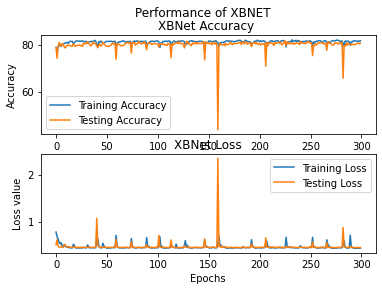

In [211]:
m,acc, lo, val_ac, val_lo = run_XBNET(X_train,X_test,y_train,y_test,model,criterion,optimizer,32,300)
# print(predict(m,x_data.to_numpy()[0,:]))

In [212]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

y_preds = predict(m,X_test)
print(classification_report(y_test, y_preds))
print('Accuracy: ' + str(accuracy_score(y_test, y_preds)))
print('F1 Score: ' + str(f1_score(y_test, y_preds, average="weighted")))
print('Precision: ' + str(precision_score(y_test, y_preds, average="weighted")))
print('Recall: ' + str(recall_score(y_test, y_preds, average="weighted")))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89       794
           1       0.65      0.13      0.21       206

    accuracy                           0.81      1000
   macro avg       0.73      0.55      0.55      1000
weighted avg       0.78      0.81      0.75      1000

Accuracy: 0.806
F1 Score: 0.7497248750822741
Precision: 0.779025
Recall: 0.806


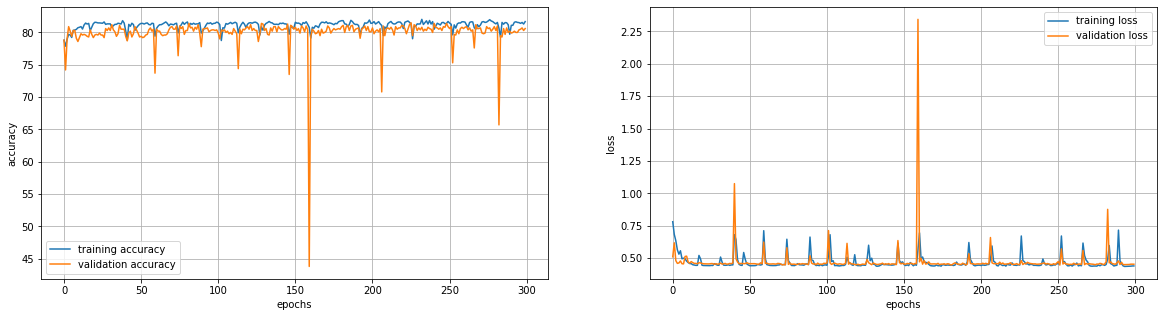

In [213]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(acc,label='training accuracy')
plt.plot(val_ac,label = 'validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.plot(lo,label='training loss')
plt.plot(val_lo,label = 'validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend() 
plt.grid()